In [1]:
import hdbscan
import numpy as np
import sklearn.cluster
import sklearn.datasets
import time
import seaborn as sns
import pandas as pd
import scipy
import fastcluster
import matplotlib.pyplot as plt
#import debacl
%matplotlib inline
sns.set_context('poster')
sns.set_palette('Paired', 10)
sns.set_color_codes()

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [3]:
def benchmark_algorithm(dataset_sizes, cluster_function, function_args, function_kwds,
                        dataset_dimension=2, max_time=45, sample_size=2):
    
    # Initialize the result with NaNs so that any unfilled entries 
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_sizes), sample_size))
    for index, size in enumerate(dataset_sizes):
        dataset_n_clusters = int(np.log2(size))
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, _ = sklearn.datasets.make_blobs(n_samples=size, 
                                                       n_features=dataset_dimension, 
                                                       centers=dataset_n_clusters)
            
            # Start the clustering with a timer
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time
            
            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                result[index, s] = time_taken
                return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size), 
                                               result.flatten()]).T, columns=['x','y'])
            else:
                result[index, s] = time_taken
        
    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size), 
                                   result.flatten()]).T, columns=['x','y'])

In [4]:
dataset_sizes = np.hstack([np.arange(1, 6) * 500, np.arange(3,7) * 1000, np.arange(4,17) * 2000])

In [5]:
k_means = sklearn.cluster.KMeans(10)
k_means_data = benchmark_algorithm(dataset_sizes, k_means.fit, (), {})


In [6]:
dbscan = sklearn.cluster.DBSCAN(eps=1.25)
dbscan_data = benchmark_algorithm(dataset_sizes, dbscan.fit, (), {})



In [7]:
scipy_k_means_data = benchmark_algorithm(dataset_sizes, scipy.cluster.vq.kmeans, (10,), {})

scipy_single_data = benchmark_algorithm(dataset_sizes, scipy.cluster.hierarchy.single, (), {})

fastclust_data = benchmark_algorithm(dataset_sizes, fastcluster.single, (), {})



In [8]:
hdbscan_ = hdbscan.HDBSCAN()
hdbscan_data = benchmark_algorithm(dataset_sizes, hdbscan_.fit, (), {})

#debacl_data = benchmark_algorithm(dataset_sizes, debacl.level_set_tree, (5, 5), {'verbose':False})



# El siguiente ejemplo  se comenta porque es de muy alto consumo. Se deja como ejercicio.

In [9]:
#agglomerative = sklearn.cluster.AgglomerativeClustering(10)
#agg_data = benchmark_algorithm(dataset_sizes, agglomerative.fit, (), {}, sample_size=4)

#spectral = sklearn.cluster.SpectralClustering(10)
#spectral_data = benchmark_algorithm(dataset_sizes, spectral.fit, (), {}, sample_size=6)
#affinity_prop = sklearn.cluster.AffinityPropagation()
#ap_data = benchmark_algorithm(dataset_sizes, affinity_prop.fit, (), {}, sample_size=3)

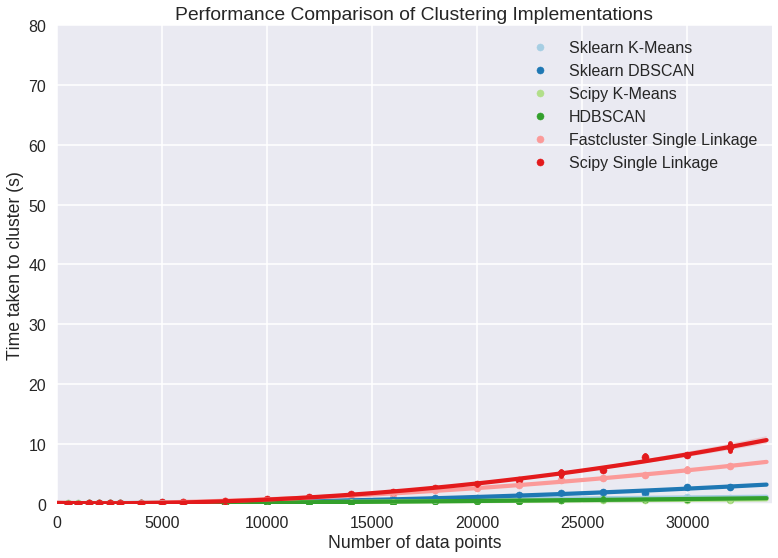

In [10]:
sns.regplot(x='x', y='y', data=k_means_data, order=2, label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=dbscan_data, order=2, label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_k_means_data, order=2, label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=hdbscan_data, order=2, label='HDBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=fastclust_data, order=2, label='Fastcluster Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_single_data, order=2, label='Scipy Single Linkage', x_estimator=np.mean)

plt.gca().axis([0, 34000, 0, 80])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Clustering Implementations')
plt.legend()



In [11]:
###implementaciones rápidas
large_dataset_sizes = np.arange(1,16) * 3000

hdbscan_prims = hdbscan.HDBSCAN(algorithm='prims_kdtree')
large_hdbscan_prims_data = benchmark_algorithm(large_dataset_sizes, 
                                         hdbscan_prims.fit, (), {}, max_time=90, sample_size=1)

hdbscan_boruvka = hdbscan.HDBSCAN(algorithm='boruvka_kdtree')
large_hdbscan_boruvka_data = benchmark_algorithm(large_dataset_sizes, 
                                         hdbscan_boruvka.fit, (), {}, max_time=90, sample_size=1)

k_means = sklearn.cluster.KMeans(10)
large_k_means_data = benchmark_algorithm(large_dataset_sizes, 
                                         k_means.fit, (), {}, max_time=90, sample_size=1)

dbscan = sklearn.cluster.DBSCAN(eps=1.25, min_samples=5)
large_dbscan_data = benchmark_algorithm(large_dataset_sizes, 
                                        dbscan.fit, (), {}, max_time=90, sample_size=1)

large_fastclust_data = benchmark_algorithm(large_dataset_sizes, 
                                           fastcluster.single, (), {}, max_time=90, sample_size=1)

large_scipy_k_means_data = benchmark_algorithm(large_dataset_sizes, 
                                               scipy.cluster.vq.kmeans, (10,), {}, max_time=90, sample_size=1)

large_scipy_single_data = benchmark_algorithm(large_dataset_sizes, 
                                              scipy.cluster.hierarchy.single, (), {}, max_time=90, sample_size=1)

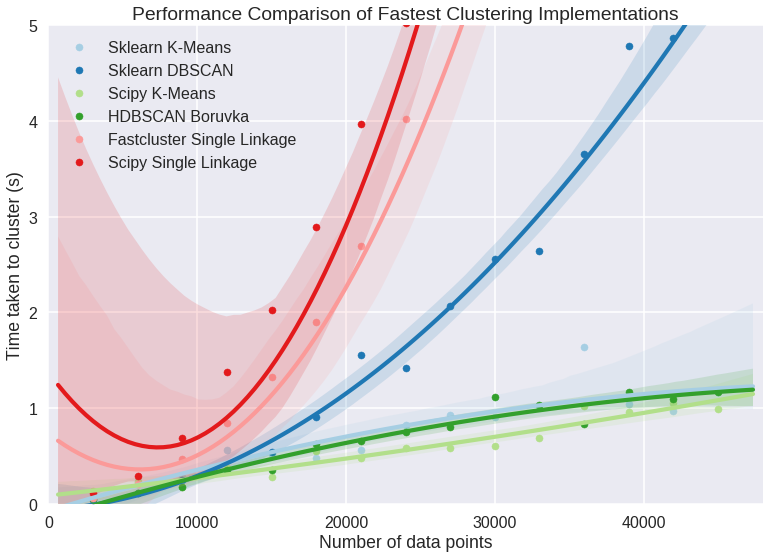

In [12]:
sns.regplot(x='x', y='y', data=large_k_means_data, order=2,
            label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_dbscan_data, order=2,
            label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_scipy_k_means_data, order=2,
            label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_hdbscan_boruvka_data, order=2,
            label='HDBSCAN Boruvka', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_fastclust_data, order=2,
            label='Fastcluster Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_scipy_single_data, order=2,
            label='Scipy Single Linkage', x_estimator=np.mean)

plt.gca().axis([0, 48000, 0, 5])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Fastest Clustering Implementations')
plt.legend()
plt.show()